In [209]:
import numpy as np
import random
from sklearn.preprocessing import normalize

import math

class World():
    def __init__(self, dims):
        self.dims = dims
        self.boids = np.array([])
    
    def setup(self, numBoids):
        for i in range(numBoids):
            self.add_boid()
            
    def add_boid(self):
        self.boids = np.append(self.boids, Boid(self))
        
    def run(self, steps, render=True):
        for b in self.boids:
            b.run()
        if render:
            self.render()
        
    def render(self):
        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=20, blit=True)
    

class Boid(object):
    def __init__(self, world):
        self.world = world
        self.boid_num = len(self.world.boids)
        dims = self.world.dims
        x = random.randint(0, dims[0])
        y = random.randint(0, dims[1])
        self.position = np.array([x, y])
        
        direction = random.random()*2*math.pi
        initialSpeed = 1
        vx = math.cos(direction)*initialSpeed
        vy = math.sin(direction)*initialSpeed
        self.velocity = np.array([vx, vy])
        
        self.maxSpeed = 3
        self.maxForce = 0.03
        self.visionAngle = math.radians(180)  # NOTE if angle > 180 is used the finding algo will need to be adjusted <- TODO
        self.desiredDist = random.randint(15,35)
        self.visionDist = self.desiredDist + random.randint(25,35)
        
        self.seenBoids = np.array([])
        self.acceleration = np.array([0, 0])
        
    def run(self):
        '''
        Find visible boids
        Separate
        Align
        Cohesion
        Avoid obstacles
        Apply Acceleration
        '''
        self.find_boids()
        
        # get forces
        sep = self.separate()
        ali = self.align()
        coh = self.cohesion()
        avo = self.avoid()
        
        # scale
        sep = 1.0 * sep
        ali = 1.0 * ali
        coh = 1.0 * coh
        avo = 1.0 * avo
        
        self.applyForces([sep, ali, coh, avo])
        
        self.update()
    
    def update(self):
        '''

        '''
        self.velocity = self.velocity + self.acceleration
        self.velocity = self.maxSpeed / np.sqrt(self.velocity @ self.velocity) * self.velocity
        self.position = self.position + self.velocity
        self.acceleration = 0 * self.acceleration
    
    def applyForces(self, forces):
        '''
        
        '''
        for f in forces:
            self.acceleration = self.acceleration + f
        
    def find_boids(self):
        '''
        This method finds boids that are within the vision distance and vision angle based on velocity direction
        '''
        dist_vecs = np.array([boid.position - self.position for boid in self.world.boids])
        mags = np.sqrt((dist_vecs*dist_vecs).sum(axis=1)) #TODO: need to check if this multiplication is done correctly '*' might not be the correct multiplication
        nearbyBoids = self.world.boids[mags < self.visionDist]

        relPoints = dist_vecs[mags < self.visionDist]
        theta = self.visionAngle/2

        clockRotationMatrix = np.array([[math.cos(-theta), -math.sin(-theta)], [math.sin(-theta), math.cos(-theta)]])
        counterRotationMatrix = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
        
        sectorStart = np.matmul(clockRotationMatrix, self.velocity)
        sectorEnd = np.matmul(counterRotationMatrix, self.velocity)
        
        visible = [not self.areClockwise(sectorStart, p) and self.areClockwise(sectorEnd, p) for p in relPoints]
        self.seenBoids = nearbyBoids[visible]
        
    def separate(self):
        count = 0
        steer = np.array([0, 0])
        for boid in self.seenBoids:
            diff = self.position - boid.position
            mag = np.sqrt(diff @ diff)
            if( mag > 0 and mag < self.desiredDist ):
                diff = diff / mag
                steer = steer + diff
                count += 1
        if count > 1:
            steer /= count

        steerMag = np.sqrt(steer @ steer)
        if ( steerMag > 0 ):
            steer = steer / steerMag
            steer = self.maxSpeed * steer
            steer -= self.velocity
            steer = self.maxForce / np.sqrt(steer @ steer) * steer
        return steer
    
    def align(self):
        count = len(self.seenBoids)
        steer = np.array([0, 0])
        for boid in self.seenBoids:
            steer = steer + boid.velocity
        
        if count > 1:
            steer /= count

        steerMag = np.sqrt(steer @ steer)
        if ( steerMag > 0 ):
            steer = steer / steerMag
            steer = self.maxSpeed * steer
            steer -= self.velocity
            steer = self.maxForce / np.sqrt(steer @ steer) * steer
        return steer
    
    def cohesion(self):
        count = len(self.seenBoids)
        if count > 0:
            p = np.array([0, 0])
            for boid in self.seenBoids:
                p = p + boid.position
            p = p / count
            desired = p - self.position
            desired = desired / np.sqrt(desired @ desired) * self.maxSpeed
            steer = desired - self.velocity
            steer = self.maxForce / np.sqrt(steer @ steer) * steer
            return steer
        else:
            return np.array([0, 0])
    
    def avoid(self):
        steer = np.array([0, 0])
        return steer
    
    def __repr__(self):
        return f'Boid {self.boid_num} at {self.position} heading {self.velocity}'
    
    def __str__(self):
        return f'Boid {self.boid_num} at {self.position} heading {self.velocity}'
    
    def areClockwise(self, v1, v2):
        return -v1[0]*v2[1] + v1[1]*v2[0] > 0

In [210]:
world = World((250, 250))
world.setup(100)

In [211]:
world.boids

array([Boid 0 at [118  85] heading [-0.34980734  0.93682166],
       Boid 1 at [81 34] heading [ 0.85368357 -0.52079205],
       Boid 2 at [197 122] heading [-0.10636282 -0.99432739],
       Boid 3 at [115  11] heading [-0.99544615 -0.09532555],
       Boid 4 at [92 87] heading [0.40858694 0.91271941],
       Boid 5 at [184 205] heading [ 0.04944606 -0.9987768 ],
       Boid 6 at [85 86] heading [-0.27128149  0.96250005],
       Boid 7 at [33  1] heading [-0.91201831 -0.41014949],
       Boid 8 at [117  60] heading [-0.01417246 -0.99989957],
       Boid 9 at [214 106] heading [0.71512513 0.69899646],
       Boid 10 at [ 68 119] heading [-0.86399083 -0.50350754],
       Boid 11 at [ 91 153] heading [-0.80712956 -0.59037435],
       Boid 12 at [235  84] heading [ 0.2359595  -0.97176289],
       Boid 13 at [ 41 136] heading [-0.99124195  0.13205833],
       Boid 14 at [228 133] heading [ 0.59199884 -0.80593882],
       Boid 15 at [185 101] heading [ 0.97804577 -0.2083902 ],
       Boid 16

In [195]:
for boid in world.boids:
    boid.run()

In [141]:
for boid in world.boids:
    boid.run()

Boid 0 at [173 165] heading [-0.86475907 -0.50218697]

In [142]:
world.boids[0].seenBoids

array([Boid 41 at [175 136] heading [ 0.88092374 -0.47325824],
       Boid 43 at [152 126] heading [ 0.96746079 -0.253021  ],
       Boid 63 at [143 187] heading [ 0.99983668 -0.0180726 ],
       Boid 91 at [181 146] heading [-0.99384115 -0.11081411],
       Boid 97 at [156 187] heading [0.34039633 0.94028205]], dtype=object)

array([190.8519516 ,  39.29617314,  13.93866422, 160.89141429,
        98.53101793, 249.53733232, 162.86877932,  56.43613971,
       156.92772573, 160.51948362,  60.81694363, 143.3939774 ,
       -10.15535634, 142.14073545, 101.42250447,  92.18129597,
       231.96581255, 230.27301248, 107.85624906, 181.36702091,
        57.21856691,  32.14786656, 108.70673402,  47.25906683,
       149.08093927, 160.06979447, 253.08521123, 164.97327743,
       247.45329794, 150.89795625, 232.68334155, 153.45255336,
       100.38044329, 117.8505663 , 156.30242849, 157.36116181,
        71.46984285, 194.8915198 , 240.76627438, 105.82435829,
       143.98013298,  48.99084109,  85.24897056,  76.74348412,
       101.34767025,  48.52496603, 155.27588647, 213.94794838,
       119.19543507, 194.01506453,   4.82637502, 215.86824496,
       169.24770828,  99.59523157, 188.24466326, 240.84808472,
        69.59169812,  93.52404076, 248.50040988, 204.78028326,
       173.81467258,  49.22688098, 211.23215326, 224.64

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

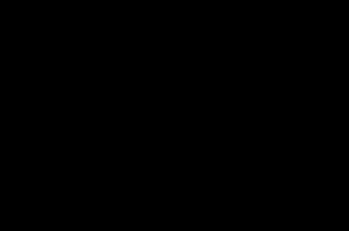

In [212]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 

%matplotlib inline



plt.style.use('dark_background')

fig = plt.figure() 
ax = plt.axes(xlim=(0, 250), ylim=(0, 250)) 

[b.position for b in world.boids]

points = ax.scatter([], [],) 

# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 

# lists to store x and y axis points 
xdata, ydata = [], [] 

# animation function 
def animate(i): 
    world.run(1, render=False)
    x = np.array([b.position for b in world.boids])[:,0]
    y = np.array([b.position for b in world.boids])[:,0]

    # appending new points to x, y axes points list 
    xdata.append(x) 
    ydata.append(y) 
    points.set_data(xdata, ydata) 
    return points, 


# hiding the axis details 
plt.axis('off') 

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=20, blit=True) 

# save the animation as mp4 video file 
anim.save('coil.gif',writer='imagemagick') 

In [205]:
ax.scatter([], [],)